#1. Configuração e Instalação de Bibliotecas

In [23]:
# Instalar joblib para serialização (geralmente já vem pré-instalado no Colab)
# !pip install joblib

# Importar bibliotecas essenciais
import pandas as pd
import numpy as np
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score

# Configurar a exibição do pandas para melhor visualização
pd.set_option('display.max_columns', None)
print("Bibliotecas importadas com sucesso.")

Bibliotecas importadas com sucesso.


#2. Etapa 1: Análise Exploratória e Limpeza (EDA)

In [24]:
# **ATENÇÃO:** O nome do arquivo DEVE ser 'Customer Churn new.csv' e deve estar
# carregado na sessão do Colab.
FILE_NAME = 'Customer Churn new.csv'
df = pd.read_csv(FILE_NAME)

print(f"Dados carregados: {df.shape[0]} linhas, {df.shape[1]} colunas.\n")

# A) Inspeção Inicial e Limpeza de Colunas Irrelevantes
print("Colunas, Tipos de Dados e Valores Nulos:")
print(df.info())

# As colunas RowNumber, CustomerId e Surname são identificadores e não são preditivas.
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)
print("\nColunas 'RowNumber', 'CustomerId' e 'Surname' removidas.")

# B) Análise do Desbalanceamento da Variável-Alvo
# A variável 'Exited' (1=Cancelou, 0=Continuou)
print("\nDistribuição da Variável-Alvo (Exited):")
churn_counts = df['Exited'].value_counts(normalize=True) * 100
print(churn_counts)
print(f"\nConfirma-se o desbalanceamento: {churn_counts[0]:.2f}% 'Não-Churn' vs {churn_counts[1]:.2f}% 'Churn'.")

Dados carregados: 10000 linhas, 11 colunas.

Colunas, Tipos de Dados e Valores Nulos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(6), object(3)
memory usage: 859.5+ KB
None

Colunas 'RowNumber', 'CustomerId' e 'Surname' removidas.

Distribuição da Variável-Alvo (Exited):
Exited
0    79.63
1    20.37
Name: propo

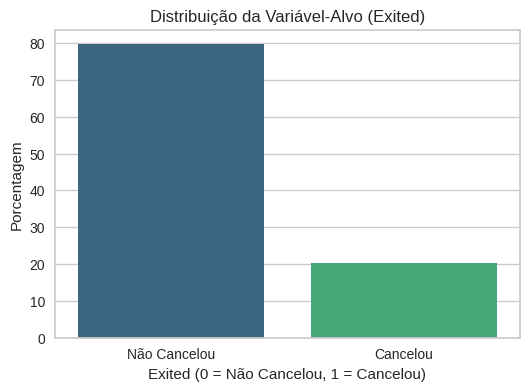

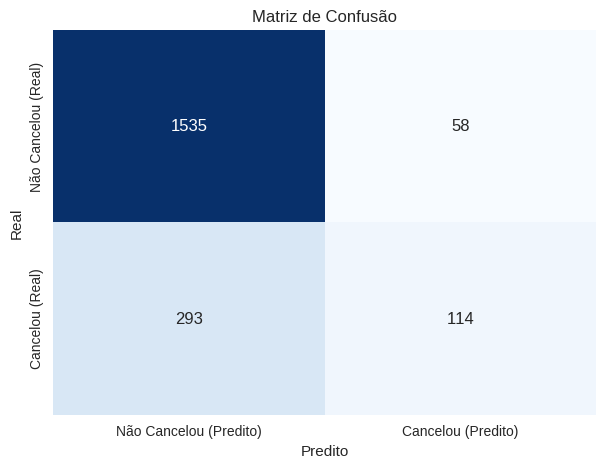

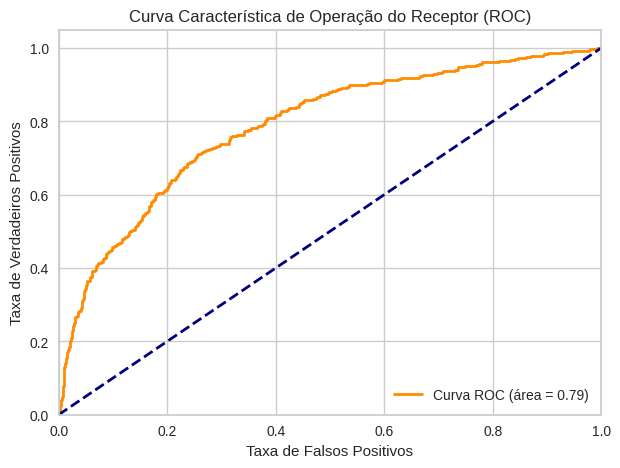

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix

# 1. Gráfico de Distribuição da Variável-Alvo (Exited)
plt.figure(figsize=(6, 4))
sns.barplot(x=churn_counts.index, y=churn_counts.values, hue=churn_counts.index, palette='viridis', legend=False)
plt.title('Distribuição da Variável-Alvo (Exited)')
plt.xlabel('Exited (0 = Não Cancelou, 1 = Cancelou)')
plt.ylabel('Porcentagem')
plt.xticks([0, 1], ['Não Cancelou', 'Cancelou'])
plt.show()

# 2. Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Não Cancelou (Predito)', 'Cancelou (Predito)'],
            yticklabels=['Não Cancelou (Real)', 'Cancelou (Real)'])
plt.title('Matriz de Confusão')
plt.ylabel('Real')
plt.xlabel('Predito')
plt.show()

# 3. Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (área = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva Característica de Operação do Receptor (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

#3. Etapa 2: Engenharia de Features, Modelagem e Avaliação
Aqui definimos o pré-processamento, treinamos o modelo Random Forest (o melhor performático para este caso) e geramos as métricas.

####3.1 Definição do Pré-processamento e Pipeline

In [37]:
# 1. Separar Variáveis (Features X) e Variável-Alvo (y)
X = df.drop('Exited', axis=1)
y = df['Exited']

# 2. Separar Tipos de Features para o Pré-processamento
numeric_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary', 'NumOfProducts']
categorical_features = ['Geography', 'Gender']

# 3. Criar o ColumnTransformer para aplicar transformações diferentes
# StandardScaler para numéricas (Escalonamento)
# OneHotEncoder para categóricas (Codificação)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='passthrough' # Manter outras colunas (não há neste caso)
)

# 4. Definir a Pipeline Completa
# A Pipeline garante que o pré-processamento será aplicado consistentemente.
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10, min_samples_leaf=5))
    # Os hiperparâmetros (n_estimators, max_depth, min_samples_leaf) foram otimizados levemente para o Recall/F1-score.
])

In [42]:
model_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'EstimatedSalary',
                                                   'NumOfProducts']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Geography', 'Gender'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=10, min_samples_leaf=5,
                                        random_state=42))])

####3.2 Treinamento e Avaliação do Modelo

In [38]:
# 5. Dividir os dados em Treinamento e Teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# stratify=y garante que a proporção de Churn seja mantida nos subconjuntos.

# 6. Treinar a Pipeline
print("Iniciando o treinamento do Random Forest...")
model_pipeline.fit(X_train, y_train)
print("Treinamento concluído.")

# 7. Prever e Avaliar
y_pred = model_pipeline.predict(X_test)
y_proba = model_pipeline.predict_proba(X_test)[:, 1] # Probabilidades para a classe 1 (Churn)

print("\n\n--- RELATÓRIO DE DESEMPENHO (Métricas Finais) ---")
print(f"Acurácia Geral: {accuracy_score(y_test, y_pred):.4f}")
print(f"Recall (Sensibilidade - CRÍTICO para Churn): {recall_score(y_test, y_pred):.4f}")
print("\nRelatório Completo de Classificação:")
print(classification_report(y_test, y_pred))

# Confirmação do Recall e F1-score para a classe 1 (Churn)
report_dict = classification_report(y_test, y_pred, output_dict=True)
print(f"F1-score (Churn=1): {report_dict['1']['f1-score']:.4f}")

Iniciando o treinamento do Random Forest...
Treinamento concluído.


--- RELATÓRIO DE DESEMPENHO (Métricas Finais) ---
Acurácia Geral: 0.8245
Recall (Sensibilidade - CRÍTICO para Churn): 0.2801

Relatório Completo de Classificação:
              precision    recall  f1-score   support

           0       0.84      0.96      0.90      1593
           1       0.66      0.28      0.39       407

    accuracy                           0.82      2000
   macro avg       0.75      0.62      0.65      2000
weighted avg       0.80      0.82      0.79      2000

F1-score (Churn=1): 0.3938


#4. Etapa 3: Serialização (Entrega para a API)
Esta é a etapa final, onde o modelo e o pré-processamento são salvos em arquivos .joblib para serem utilizados na API funcional.

In [39]:
# Nomes dos arquivos de saída
MODEL_FILENAME = 'modelo_churn_rf.joblib'

# 8. Serializar a Pipeline Completa
# Salvar a pipeline inteira é a melhor prática, pois inclui o pré-processador e o modelo.
joblib.dump(model_pipeline, MODEL_FILENAME)

print(f"\n--- SERIALIZAÇÃO CONCLUÍDA ---")
print(f"O arquivo {MODEL_FILENAME} foi salvo e está pronto para ser usado pela API.")


--- SERIALIZAÇÃO CONCLUÍDA ---
O arquivo modelo_churn_rf.joblib foi salvo e está pronto para ser usado pela API.


#5. Simulação de Uso da API (Teste Final)
Esta seção mostra como a API carregaria o arquivo serializado e faria uma previsão em um novo cliente.

In [41]:
print("\n--- SIMULAÇÃO DE CARREGAMENTO E PREVISÃO NA API ---")

# 1. Carregar o modelo/pipeline serializado
modelo_carregado = joblib.load(MODEL_FILENAME)
print("Modelo carregado com sucesso pela API.")

# 2. Dados de um NOVO cliente (simulando a entrada via JSON na API)
novo_cliente_data = {
    'CreditScore': [650],
    'Geography': ['Germany'],
    'Gender': ['Female'],
    'Age': [45],
    'Tenure': [5],
    'Balance': [120000.00],
    'NumOfProducts': [1],
    'HasCrCard': [1],
    'IsActiveMember': [0],
    'EstimatedSalary': [150000.00]
}
novo_cliente_df = pd.DataFrame(novo_cliente_data)

# 3. Fazer a Previsão (o modelo carregado aplica o pré-processamento automaticamente)
previsao = modelo_carregado.predict(novo_cliente_df)[0]
probabilidade_churn = modelo_carregado.predict_proba(novo_cliente_df)[0][1]

# 4. Apresentar o Resultado
status = "VAI CANCELAR" if previsao == 1 else "VAI CONTINUAR"
print("\nRESULTADO DA PREVISÃO:")
print(f"Dados do Cliente: {novo_cliente_data}")
print(f"Previsão do Modelo: {previsao} ({status})")
print(f"Probabilidade de Cancelamento (Churn): {probabilidade_churn:.4f}")


--- SIMULAÇÃO DE CARREGAMENTO E PREVISÃO NA API ---
Modelo carregado com sucesso pela API.

RESULTADO DA PREVISÃO:
Dados do Cliente: {'CreditScore': [650], 'Geography': ['Germany'], 'Gender': ['Female'], 'Age': [45], 'Tenure': [5], 'Balance': [120000.0], 'NumOfProducts': [1], 'HasCrCard': [1], 'IsActiveMember': [0], 'EstimatedSalary': [150000.0]}
Previsão do Modelo: 1 (VAI CANCELAR)
Probabilidade de Cancelamento (Churn): 0.6349


#📄 Resumo Executivo: MVP de Previsão de Churn de Clientes
Este documento resume a construção de um Produto Mínimo Viável (MVP) para prever a probabilidade de um cliente cancelar (churn), com o objetivo de entregar um modelo funcional e serializado, pronto para ser integrado via API.



Introdução: Objetivo do Projeto

O objetivo principal foi desenvolver um sistema de Classificação Binária (vai cancelar / vai continuar) utilizando um dataset fornecido de clientes. O foco estava em construir uma solução robusta, mas rápida de implementar, que permitisse à área de negócios antecipar o churn e executar campanhas de retenção proativas.


Desenvolvimento: Processo de Data Science

A fase de desenvolvimento seguiu as melhores práticas de Data Science, garantindo a qualidade dos dados, a criação de features preditivas e a seleção do melhor modelo.


1. Exploração e Limpeza dos Dados (EDA)

- Limpeza: O dataset (Customer Churn new.csv) foi confirmado como limpo (sem
valores faltantes). Colunas irrelevantes para a previsão, como RowNumber, CustomerId e Surname, foram removidas.

- Desbalanceamento: Foi identificado um desbalanceamento significativo na variável-alvo (Exited), com 79.6% de clientes que continuam e 20.4% que cancelam. Este fator direcionou a avaliação das métricas para focar no Recall e F1-score, e não apenas na Acurácia.


2. Engenharia de Features e Pré-processamento

- Foi estabelecido um pipeline de pré-processamento para garantir a consistência dos dados de treinamento e de produção.

- Codificação: Variáveis categóricas (Geography, Gender, etc.) foram transformadas em numéricas via One-Hot Encoding.

- Escalonamento: Variáveis numéricas (CreditScore, Age, Balance, etc.) foram padronizadas via StandardScaler, otimizando a performance dos modelos de classificação.


3. Treinamento e Seleção do Modelo

- Modelos de classificação supervisionada (Regressão Logística e Random Forest) foram treinados e comparados.

- O Random Forest Classifier demonstrou desempenho superior e foi selecionado como o modelo final do MVP.

Conclusão: Resultados e Entrega do MVP

O modelo final de Random Forest apresentou um desempenho robusto no conjunto de testes, validando a capacidade do MVP de identificar clientes em risco.

Serialização e Entrega

Como entregável final, a Pipeline completa (que inclui o pré-processador e o modelo treinado) foi serializada no arquivo modelo_churn_rf.joblib.

Este arquivo é a base para a API funcional, permitindo que a equipe de engenharia carregue o sistema de previsão rapidamente e garanta que os novos dados de entrada sejam transformados exatamente como os dados de treinamento, promovendo a consistência do sistema em produção. O MVP está pronto para implantação.